In [60]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from shapely.geometry import Point
from shapely import wkt
from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier,
                              GradientBoostingClassifier, AdaBoostClassifier,
                              BaggingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score
import osmnx as ox
import shap
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

In [61]:
gdf = pd.read_csv('flood.csv', index_col=0)
gdf

,lat,lon,flood_heig,elevation,precipitat,geometry,grassland,sand,scree,scrub,...,wetland,wood,canal,lake,pond,river,wastewater,Dist,surrounding_elevation,surrounding_height
0,14.736958,121.048226,0,70.024704,14.0,POINT (121.0482261 14.73695808),0.0,0.0,0,1,...,0,0,0,0,0.0,0,0.0,0.080185,57.754128,0
1,14.757315,121.073106,0,90.170433,16.0,POINT (121.0731063 14.75731464),1.0,0.0,0,0,...,0,1,0,0,0.0,0,0.0,0.102027,73.567432,0
2,14.657517,121.068553,0,70.874069,11.0,POINT (121.0685528 14.65751742),1.0,0.0,0,0,...,0,1,0,1,0.0,1,0.0,0.014139,70.506702,0
3,14.532866,121.017090,0,10.096975,7.0,POINT (121.01709 14.532866),0.0,23.0,0,1,...,0,0,0,0,0.0,0,0.0,0.129639,8.995107,2
4,14.577561,121.032944,0,5.643910,8.0,POINT (121.032944 14.577561),0.0,0.0,0,0,...,0,1,0,0,0.0,1,0.0,0.082304,7.130371,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,14.565436,121.132076,2,12.006505,14.0,POINT (121.1320759 14.56543575),0.0,0.0,0,0,...,0,1,0,0,0.0,1,0.0,0.120068,11.934717,0
2704,14.633785,120.978465,2,8.572678,8.0,POINT (120.9784651 14.63378496),0.0,0.0,0,0,...,0,0,0,0,0.0,1,6.0,0.079430,10.824492,0
2705,14.563166,121.121095,2,5.772885,13.0,POINT (121.121095 14.56316553),0.0,0.0,0,0,...,0,0,0,0,0.0,1,0.0,0.115119,6.726489,0
2706,14.549214,121.028014,2,22.342602,7.0,POINT (121.0280143 14.54921401),0.0,0.0,0,0,...,0,0,0,0,0.0,0,0.0,0.110987,22.817686,0


# No Tuning, Removed Spatially Autocorrelated Features

In [ ]:
y = gdf['flood_heig']
X = gdf.drop(['flood_heig', 'geometry', 'lat', 'lon', 'Dist',
              'surrounding_elevation', 'surrounding_height'], axis=1)


classifiers = [KNeighborsClassifier(),
               GaussianNB(),
               LogisticRegression(penalty='l1', solver='liblinear', n_jobs=-1),
               LogisticRegression(penalty='l2', max_iter=100000, n_jobs=-1),
               LinearSVC(penalty='l1', dual=False),
               LinearSVC(penalty='l2'),
               SVC(),
               DecisionTreeClassifier(),
               RandomForestClassifier(n_jobs=-1),
               ExtraTreesClassifier(n_jobs=-1),
               AdaBoostClassifier(),
               BaggingClassifier(n_jobs=-1),
               GradientBoostingClassifier(),
               MLPClassifier()]

train_acc_results = []
test_acc_results = []
train_f1_results = []
test_f1_results = []
run_time = []


for model in tqdm(classifiers):
    train_acc = []
    train_f1 = []
    test_acc = []
    test_f1 = []
    start_time = time.time()
    
    for seed in tqdm(range(20)):
        # cross-val
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.20,
                                                            stratify=y,
                                                            random_state=seed)

        model.fit(X_train, y_train)
        
        y_pred_train = model.predict(X_train)
        train_acc.append(accuracy_score(y_pred_train, y_train))
        train_f1.append(f1_score(y_pred_train, y_train, average='weighted'))
        
        y_pred_test = model.predict(X_test)
        test_acc.append(accuracy_score(y_pred_test, y_test))
        test_f1.append(f1_score(y_pred_test, y_test, average='weighted'))
    
    train_acc_results.append(np.mean(train_acc))
    test_acc_results.append(np.mean(test_acc))
    train_f1_results.append(np.mean(train_f1))
    test_f1_results.append(np.mean(test_f1))
    run_time.append(time.time() - start_time)

In [ ]:
df_results = pd.DataFrame([train_acc_results, train_f1_results,
                           test_acc_results, test_f1_results,
                           run_time]).T
df_results.columns = ['Training Accuracy', 'Training F1-Score',
                      'Testing Accuracy', 'Testing F1-Score',
                      'Run Time']
#df_results.index = [str(clf) for clf in classifiers]
df_results.index = ['kNN', 'Gaussian Naive-Bayes',
                    'Ridge Classifier', 'Lasso Classifier', 
                    'Linear SVC - L1 Regularized', 'Linear SVC - L2 Regularized',
                    'Non-linear SVC', 'Decision Tree Classifier',
                    'Random Forest Classifier', 'Extra Trees Classifier',
                    'AdaBoost Classifier', 'Bagging Classifier',
                    'Gradient Boosting Classifier',
                    'Multi Layer Perceptron Neural Network']
df_results

# No Tuning, Added Spatially Autocorrelated Features

In [ ]:
y = gdf['flood_heig']
X = gdf.drop(['flood_heig', 'geometry', 'lat', 'lon', 'Dist'], axis=1)


classifiers = [KNeighborsClassifier(),
               GaussianNB(),
               LogisticRegression(penalty='l1', solver='liblinear', n_jobs=-1),
               LogisticRegression(penalty='l2', max_iter=100000, n_jobs=-1),
               LinearSVC(penalty='l1', dual=False),
               LinearSVC(penalty='l2'),
               SVC(),
               DecisionTreeClassifier(),
               RandomForestClassifier(n_jobs=-1),
               ExtraTreesClassifier(n_jobs=-1),
               AdaBoostClassifier(),
               BaggingClassifier(n_jobs=-1),
               GradientBoostingClassifier(),
               MLPClassifier()]

train_acc_results = []
test_acc_results = []
train_f1_results = []
test_f1_results = []
run_time = []


for model in tqdm(classifiers):
    train_acc = []
    train_f1 = []
    test_acc = []
    test_f1 = []
    start_time = time.time()
    
    for seed in tqdm(range(20)):
        # cross-val
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.20,
                                                            stratify=y,
                                                            random_state=seed)

        model.fit(X_train, y_train)
        
        y_pred_train = model.predict(X_train)
        train_acc.append(accuracy_score(y_pred_train, y_train))
        train_f1.append(f1_score(y_pred_train, y_train, average='weighted'))
        
        y_pred_test = model.predict(X_test)
        test_acc.append(accuracy_score(y_pred_test, y_test))
        test_f1.append(f1_score(y_pred_test, y_test, average='weighted'))
    
    train_acc_results.append(np.mean(train_acc))
    test_acc_results.append(np.mean(test_acc))
    train_f1_results.append(np.mean(train_f1))
    test_f1_results.append(np.mean(test_f1))
    run_time.append(time.time() - start_time)

In [ ]:
df_results = pd.DataFrame([train_acc_results, train_f1_results,
                           test_acc_results, test_f1_results,
                           run_time]).T
df_results.columns = ['Training Accuracy', 'Training F1-Score',
                      'Testing Accuracy', 'Testing F1-Score',
                      'Run Time']
#df_results.index = [str(clf) for clf in classifiers]
df_results.index = ['kNN', 'Gaussian Naive-Bayes',
                    'Ridge Classifier', 'Lasso Classifier', 
                    'Linear SVC - L1 Regularized', 'Linear SVC - L2 Regularized',
                    'Non-linear SVC', 'Decision Tree Classifier',
                    'Random Forest Classifier', 'Extra Trees Classifier',
                    'AdaBoost Classifier', 'Bagging Classifier',
                    'Gradient Boosting Classifier',
                    'Multi Layer Perceptron Neural Network']
df_results

# Hyperparameter Tuning

In [ ]:
y = gdf['flood_heig']
X = gdf.drop(['flood_heig', 'geometry', 'lat', 'lon', 'Dist'], axis=1)


depth_list = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
rf_train_acc_results = []
rf_test_acc_results = []
rf_train_f1_results = []
rf_test_f1_results = []

for depth in tqdm(depth_list):
    rf_train_acc = []
    rf_train_f1 = []
    rf_test_acc = []
    rf_test_f1 = []
    
    for seed in range(20):
        # cross-val
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=0.20,
                                                            stratify=y,
                                                            random_state=seed)

        model = RandomForestClassifier(max_depth=depth, n_jobs=-1)
        model.fit(X_train, y_train)
        
        y_pred_train = model.predict(X_train)
        rf_train_acc.append(accuracy_score(y_pred_train, y_train))
        rf_train_f1.append(f1_score(y_pred_train, y_train, average='weighted'))

        y_pred_test = model.predict(X_test)
        rf_test_acc.append(accuracy_score(y_pred_test, y_test))
        rf_test_f1.append(f1_score(y_pred_test, y_test, average='weighted'))
    
    rf_train_acc_results.append(np.mean(rf_train_acc))
    rf_test_acc_results.append(np.mean(rf_test_acc))
    rf_train_f1_results.append(np.mean(rf_train_f1))
    rf_test_f1_results.append(np.mean(rf_test_f1))
    
tuning = pd.DataFrame([depth_list,
                       rf_train_acc_results, 
                       rf_train_f1_results,
                       rf_test_acc_results, 
                       rf_test_f1_results]).T
tuning.columns = ['Max Depth', 'Training Accuracy', 'Training F1-Score',
                      'Testing Accuracy', 'Testing F1-Score']
tuning

# Model Interpretability with SHAP

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(tuning['Max Depth'], tuning['Testing F1-Score'], label='F1-Score',
        color='green', marker='.', markersize=20)
ax.plot(tuning['Max Depth'], tuning['Testing Accuracy'], label='Accuracy',
        color='hotpink', marker='.', markersize=20)
ax.legend()
ax.set_title('Max Depth Hyperparameter Tuning of Random Forest Classifier\n',
             fontsize=16)
ax.set_xlabel('Max Depth')
ax.set_ylabel('Model Score')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [62]:
model = RandomForestClassifier(random_state=143)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=143, 
                                                    shuffle=True,
                                                    stratify=y)
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model, X_test.to_numpy())

# generate shap values
shap_values = explainer.shap_values(X_test.to_numpy(),
                                    check_additivity=False)

 98%|===================| 1598/1626 [00:48<00:00]        

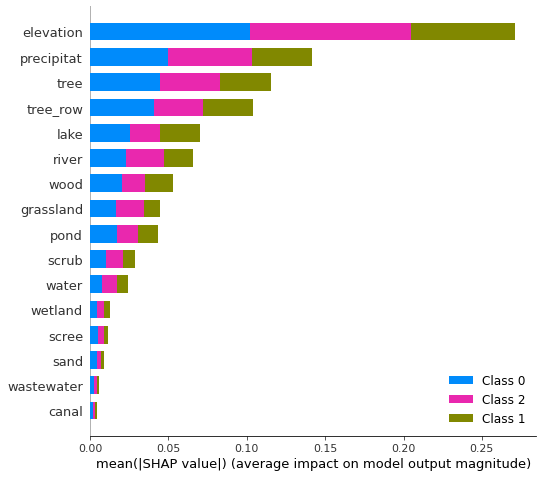

In [63]:
# summarize the effects of all the features
shap.summary_plot(shap_values = shap_values, 
                  features = X_test.columns)

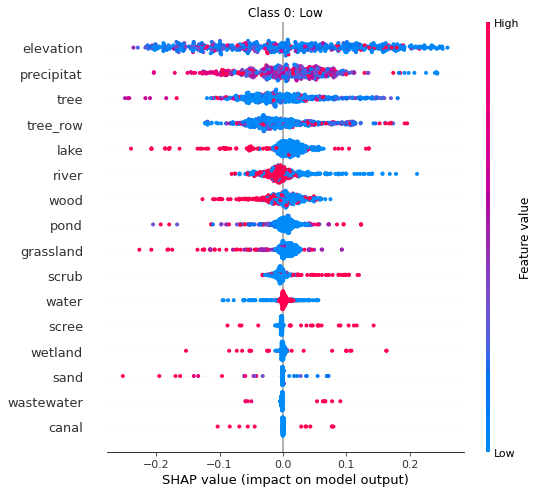

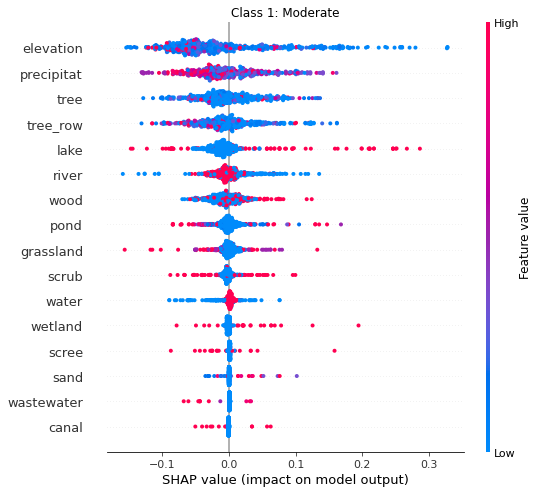

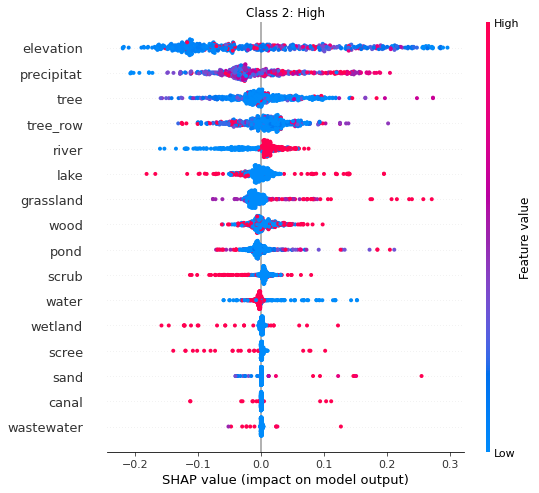

In [64]:
classes = ['Low', 'Moderate', 'High'] 

for i, group in list(zip(range(3), classes)):
    shap.summary_plot(shap_values[i], X_test.to_numpy(), show=False,
                      feature_names=list(X_test.columns))
    plt.title(f'Class {i}: {group}')
    plt.show()